# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [28]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [29]:
import pickle
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [30]:
# Load pickled data

# where you saved the training and testing data

training_file = './data/train.p'
validation_file='./data/valid.p'
testing_file = './data/test.p'
classes_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print('Image Shape: {}'.format(X_train[0].shape))
print()
print('Training Set: {} Samples'.format(len(X_train)))
print('Validation Set: {}'.format(len(X_valid)))
print('Testing Set: {}'.format(len(X_test)))
print()


Image Shape: (32, 32, 3)

Training Set: 34799 Samples
Validation Set: 4410
Testing Set: 12630



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [31]:
def getLabelsInfo():
    label_indices = []
    label_names = []
    with open(classes_file,'r') as fl:
        reader = csv.reader( fl )
        for row in reader:
            if row[0].isdecimal():
                label_indices.append( row[0] )
                label_names.append( row[1] )

    
    return label_indices, label_names

In [32]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

labels_info = getLabelsInfo()

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [33]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
%matplotlib inline

def split_by_class(y_data) :
    """
    Returns a dictionary whose keys are the class labels 
    and key values are list of indices with that class label.
    """
    img_index = {}
    labels = set(y_data)
    for i,y in enumerate(y_data) :
        if y not in img_index.keys() :
            img_index[y] = [i]
        else :
            img_index[y].append(i)
    return img_index
    

def visualize_sample_signs(X_data, y_data, i_start='random') :
    """
    Displays images from each class, 
    i_start is the starting index in each class.
    By default, images are randomly chosen from each class
    """
    img_index = split_by_class(y_data)
    labels = list(set(y_data))[::-1]
    fig, axes = plt.subplots(3, 15, figsize=(15, 3))
    for ax in axes.flatten() :
        if labels : 
            i_img=0
            if i_start == 'random':
                i_img = random.choice(img_index[labels.pop()])  
            else : 
                i_img = img_index[labels.pop()][i_start]
            ax.imshow(X_train[i_img])
        ax.axis('off')

Variation within each class
There seems to be a significant variation in lighting for randomly chosen images within a class. This is illustarted in two randomly chosen samples from each class :

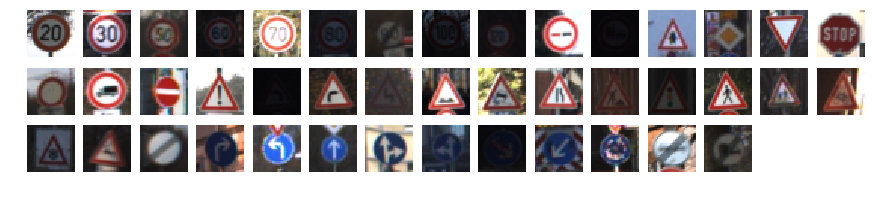

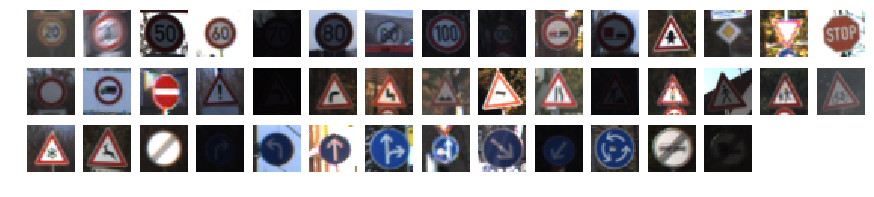

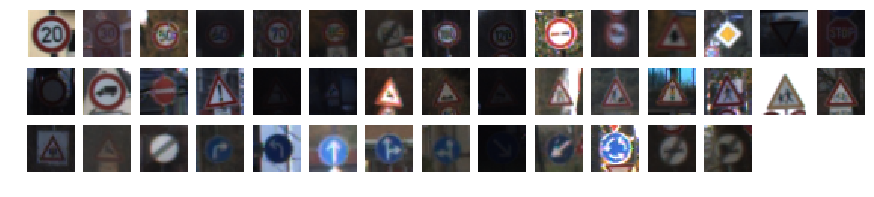

In [34]:
visualize_sample_signs(X_train, y_train)
visualize_sample_signs(X_train, y_train)
visualize_sample_signs(X_train, y_train, i_start=0)

#### Similarity in sample images

As we saw in the random images, there are so many similar images in the training and validation dataset. This is probably dues to the way the vehicle captured these images in a very small intervals. We define these images as they belong to the same 'track' by defining the similarity between images. This is because training the CNN on tracked images will not be efficient and not random enough.
Below shows how to identify sililarities with OpenCV:


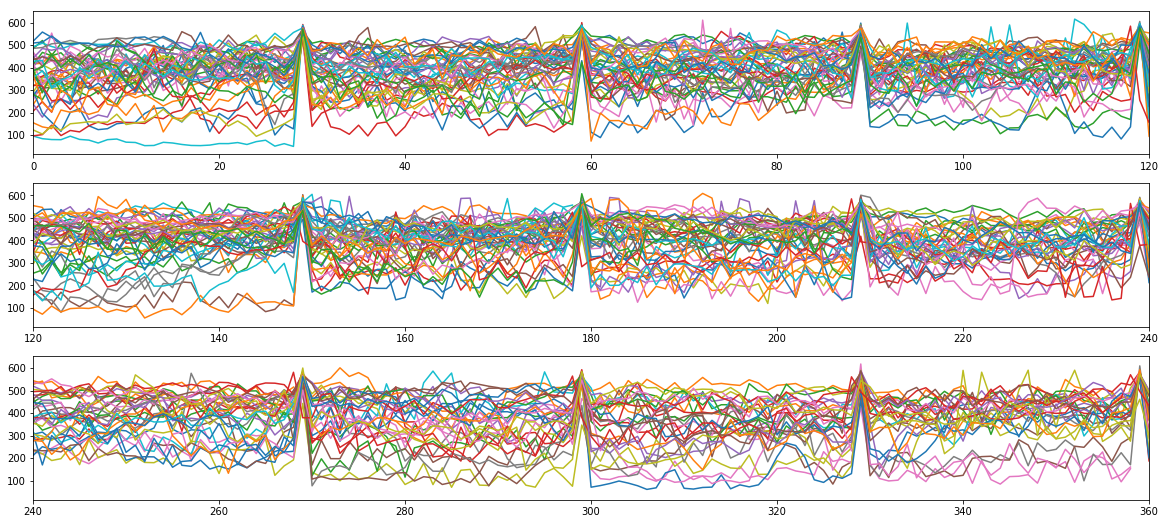

In [35]:
def calc_similarity_index(img1, img2):
    '''
    Calculates the similarity index between two images
    By using Euclidian distance
    '''
    return (np.sum(np.square(img1.flatten() - img2.flatten())))**.5

def display_image_similarity(X_data, y_data, nrows=3) :
    img_index = split_by_class(y_data)
    fig, axes = plt.subplots(nrows, 1, figsize=(20,3*nrows))
    
    for i,ax in enumerate(axes) :
        ax.set_xlim([i*120, (i+1)*120])
        
    for label in range(n_classes) :
        sim = []
        for i in range(1, len(img_index[label])) :
            sim.append(calc_similarity_index(X_data[img_index[label][i]], X_data[img_index[label][i-1]]))
        for ax in axes :
            ax.plot(sim)
        
display_image_similarity(X_train,y_train)

### Image Distribution

Following shows smaples classes distribution. As observed  a right skewed distribution for all datasets, which means the mode is larger than median and mean. 

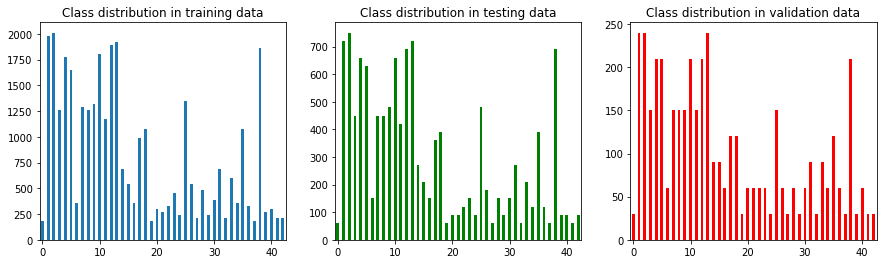

In [36]:
def plot_dist(y_data, title=None, ax=None, fig_size=None, **kwargs) :
    if not ax :
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_classes + 1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_classes - 0.5)
    if 'label' in kwargs: 
        ax.legend()
    if title: 
        ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(15,4))

plot_dist(y_train, title='Class distribution in training data', ax=ax[0], rwidth=0.5)
plot_dist(y_valid, title='Class distribution in validation data', ax=ax[2], color='red', rwidth=0.5)
plot_dist(y_test, title='Class distribution in testing data', ax=ax[1], color='green', rwidth=0.5)

The class ditribution in train, validation, and test sets look very similar. Even if we did not balance dataset, it is possible to obtain a reasonable accuracy for this particular testset. However, for new test sets with different class distributions, accuracy will go down. Therefore, we will balance our training set later by data augmentation.
Below we are looking all three sets distribution of classes.

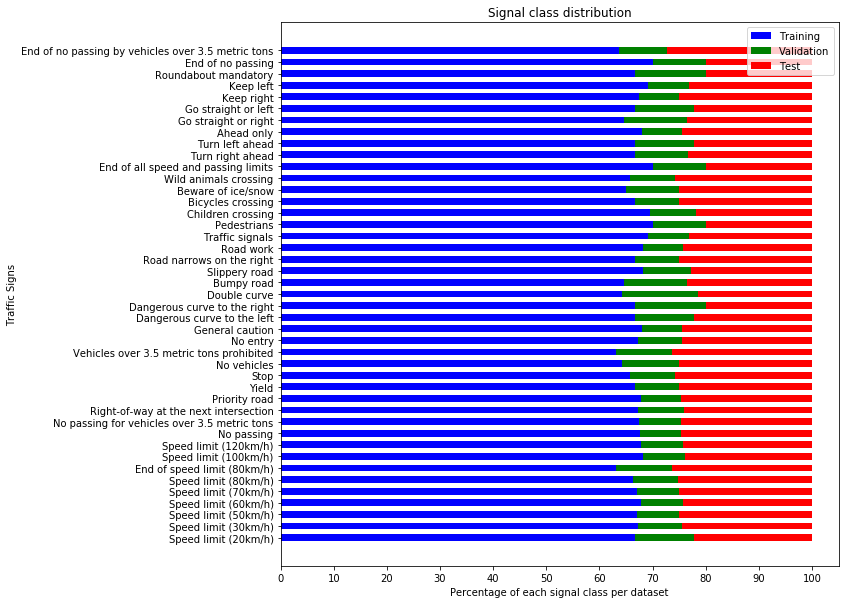

In [37]:
#%% Plot signal class distribution in the train, validation and test datasets
labels_info = getLabelsInfo();

label_ids_in_train = np.zeros( len(labels_info[0]) )
label_ids_in_valid = np.zeros( len(labels_info[0]) )
label_ids_in_test  = np.zeros( len(labels_info[0]) )

    
unique, counts = np.unique(y_train, return_counts=True)
for index, count in zip(unique, counts):
    label_ids_in_train[index] = count
    

unique, counts = np.unique(y_valid, return_counts=True)
for index, count in zip(unique, counts):
    label_ids_in_valid[index] = count

unique, counts = np.unique(y_test, return_counts=True)
for index, count in zip(unique, counts):
    label_ids_in_test[index] = count
    
for index in range(len(labels_info[0])):
    sum_tot = label_ids_in_train[index] + label_ids_in_valid[index] + label_ids_in_test[index]
    label_ids_in_train[index] = label_ids_in_train[index] / sum_tot * 100.0
    label_ids_in_valid[index] = label_ids_in_valid[index] / sum_tot * 100.0
    label_ids_in_test[index] =  label_ids_in_test[index]  / sum_tot * 100.0
    
ind = np.arange( len(labels_info[0]) )    # the x locations for the groups
height = 0.6       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(10,10))
p1 = plt.barh(ind, label_ids_in_train, height, color='blue')
p2 = plt.barh(ind, label_ids_in_valid, height, left= label_ids_in_train, color='green')
p3 = plt.barh(ind, label_ids_in_test, height, left= label_ids_in_train+ label_ids_in_valid, color='red')

plt.ylabel('Traffic Signs')
plt.title('Signal class distribution')
plt.yticks(ind, labels_info[1])
plt.xticks(np.arange(0, 110, 10))
plt.xlabel('Percentage of each signal class per dataset')
plt.legend((p1[0], p2[0], p3[0]), ('Training', 'Validation','Test'))

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

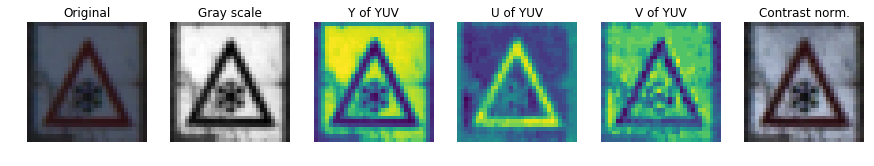

In [38]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### Preprocess the data 
def MinMaxNorm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def AbsNorm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def grayscale_norm(image) :
    # convert to grayscale 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return MinMaxNorm(img)

def YUV_norm(image) :
    # convert to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # normalize the Y channel
    [y,u,v] = [new_image[:,:,i] for i in range(3)]
    new_image = np.zeros(image.shape)
    new_image[:,:,0] = MinMaxNorm(y)
    new_image[:,:,1],new_image[:,:,2] = AbsNorm(u), AbsNorm(v)
    return new_image

def contrast_norm(image) :
    # convert to  lab colorspace
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # apply adative histogram equalization 
    l = lab[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    lab[:,:,0] = cl
    # convert back to RGB and scale values 
    img =  cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    for i in range(3) :
        new_img[:,:,i] = AbsNorm(img[:,:,i])
    return new_img

img_index = split_by_class(y_train)
img = X_train[img_index[30][20]]
fig, ax = plt.subplots(1,6, figsize=(15,3))

for axes in ax :
    axes.axis('off')
    
# original image
ax[0].imshow(img)
ax[0].set_title('Original')

# grayscale normalized 
ax[1].imshow(grayscale_norm(img), cmap='gray')
ax[1].set_title('Gray scale')

# YUV normalized (Y channel) 
ax[2].imshow(YUV_norm(img)[:,:,0])
ax[2].set_title('Y of YUV')

# YUV normalized (U channel) 
ax[3].imshow(YUV_norm(img)[:,:,1])
ax[3].set_title('U of YUV')

# YUV normalized (V channel) 
ax[4].imshow(YUV_norm(img)[:,:,2])
ax[4].set_title('V of YUV')

# Contrast normalized 
ax[5].imshow(contrast_norm(img))
ax[5].set_title('Contrast norm.')

The Y is similar to the grayscale,


We want to separate the given data into training and validation sets. For better accuracy, we need to ensure that images in the same track do not get divided between training and validation sets since they are very similar. For validation set, we randomly select 2 tracks per class from the entire training dataset.

New training data shape is :  (33509, 32, 32, 3)
Validation data shape is :  (1290, 32, 32, 3)


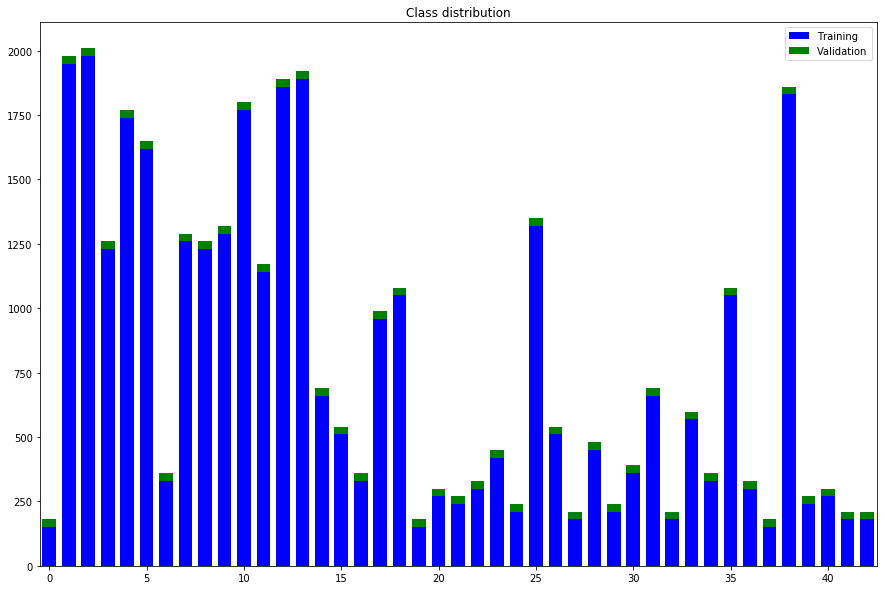

In [39]:
### Generate additional data 
### and split the data into training/validation/testing sets here.

def split_train_validation(X_data, y_data) :
    '''
    Splits data into training and validations sets based on tracks
    such that all images from a track are confined to either training 
    or validation sets but not both.
    '''
    X_train_new, y_train_new = [],[]
    X_validation, y_validation = [], []
    
    n_per_track = 30 # images per track
    img_index = split_by_class(y_data)
    for label in range(n_classes) : 
        indices = img_index[label]
        n_tracks = round(len(indices)/n_per_track) # number of tracks for this label
        X_list = np.array_split(X_data[indices[0]:indices[-1]+1], n_tracks)
        y_list = np.array_split(y_data[indices[0]:indices[-1]+1], n_tracks)
        X_list,y_list = shuffle(X_list,y_list, random_state=0)
        X_validation += X_list[:1]
        y_validation += y_list[:1]
        X_train_new += X_list[1:]
        y_train_new += y_list[1:]
        
    return (np.concatenate(X_train_new), np.concatenate(y_train_new), 
            np.concatenate(X_validation), np.concatenate(y_validation))

# sanity check
X_train_new, y_train_new, X_validation, y_validation = split_train_validation(X_train, y_train)

print("New training data shape is : ", X_train_new.shape)
print("Validation data shape is : ", X_validation.shape)

plot_dist([y_train_new, y_validation], title='Class distribution', fig_size=(15, 10), 
          label=['Training','Validation'], color=['blue','green'], rwidth=0.7)

Next, we need to generate fake data for several reasons :
To balance our dataset
For training purposes, ideally we should have had lot of tracks and only a few images per track but this is not the case.
In general, small perturbations in our original dataset will increase robustness of CNNs later.
We will generate fake data by performing geometric transformations. Some useful functions for these transformations are defined below :

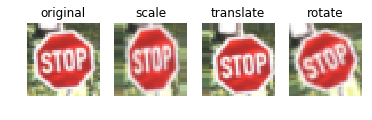

In [40]:
def scale(img, x_scale=0.85, y_scale=1.15) :
    r,c = img.shape[:-1]
    scaled_img = cv2.resize(img,None,fx=x_scale,fy=y_scale)
    new_img = cv2.copyMakeBorder(scaled_img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

def translate(img, delta_x=2, delta_y=-2):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2)+ delta_y, round((cols-c)/2)- delta_x
    return new_img[r0:r0+r, c0:c0+c]

def rotate(img, theta=18):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2), theta, 1)
    new_img = cv2.warpAffine(new_img,M,(cols,rows))
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

    
def original(img): 
    return img

img = X_train[img_index[14][200]]

fig, ax = plt.subplots(1,4, figsize=(6,2))
for i,transform in enumerate([original, scale, translate, rotate]):
    tr_img = transform(img)
    ax[i].imshow(tr_img)
    ax[i].axis('off')
    ax[i].set_title(transform.__name__)

Now, Let's randomize and combine these transformations:

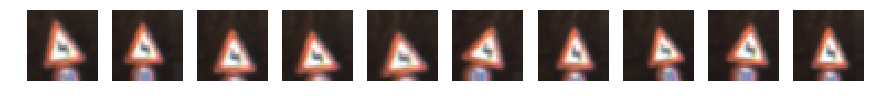

In [41]:
random_scale = lambda img : scale(img, x_scale=random.uniform(0.85,1.1), y_scale=random.uniform(0.85,1.1))
random_translate = lambda img : translate(img, delta_x=random.randint(-2,2), delta_y=random.randint(-2,2))
random_rotate = lambda img : rotate(img, theta=random.uniform(-17.,17.))

def random_transform(img) :
    new_img = img
    transform_list = [random_scale, random_translate, random_rotate]
    random.shuffle(transform_list)
    for transform in transform_list :
        new_img = transform(new_img)
    return new_img

# check
img = X_train[img_index[21][10]]
fig, ax = plt.subplots(1,10, figsize=(15,2))
for i in range(10) :
    ax[i].imshow(random_transform(img))
    ax[i].axis('off')


As already explained, we have a problem that most consecutive images are strongly correlated because they belong to the same track. To fix this problem, we apply random image transforms to every odd numbered image in training dataset with the idea being that consecutive images have similar resolution. Further, we augment existing dataset to make it balanced by requiring 3000 examples per class in training set.

Training dataset augmentation


Data augmentation: 100%|██████████| 43/43 [00:10<00:00,  3.54class/s]


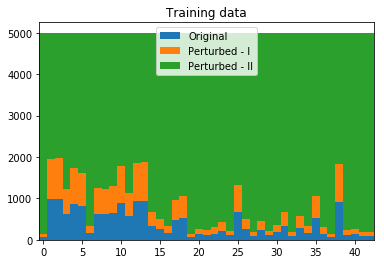

In [42]:
def perturb_data(X_data, y_data):
    """
    splits dataset retaining half the original images 
    while perturbing the other half of the images 
    """
    X_old, y_old = [], []
    X_new, y_new = [], []
    images_pbar = tqdm(X_data, unit='images', desc='Original data perturbation')
    for i,img in enumerate(images_pbar) :
        if i%2 == 0 : 
            X_old.append(img) 
            y_old.append(y_data[i])
        else :
            X_new.append(random_transform(img))
            y_new.append(y_data[i])
    return (np.array(X_old), np.array(y_old), 
            np.array(X_new), np.array(y_new))
        

def augment_data(X_data, y_data, n=300):
    """
    augments dataset so that there are n images per class
    """
    X_data_fake, y_data_fake = [],[]
    img_index = split_by_class(y_data)
    labels_pbar = tqdm(range(n_classes), unit='class', desc='Data augmentation')
    for label in labels_pbar:
        n_fake = n-len(img_index[label])
        if n_fake <= 0 : continue
        for i in range(n_fake):
            i_img = random.choice(img_index[label])
            img = X_data[i_img]
            X_data_fake.append(random_transform(img))
            y_data_fake.append(label)
    return np.array(X_data_fake),np.array(y_data_fake)


# generate training data with 5000 images per class
from time import sleep
print('Training dataset augmentation')
sleep(1)
X_train_given, y_train_given, X_train_pert, y_train_pert = perturb_data(X_train_new, y_train_new)
X_train_fake, y_train_fake = augment_data(X_train_new, y_train_new, n=5000)
del X_train_new, y_train_new


# check if distributions are as expected
plot_dist([y_train_given,y_train_pert, y_train_fake], title='Training data', \
          label=['Original','Perturbed - I','Perturbed - II'])

In [43]:
from sklearn.utils import shuffle
from time import sleep 

# combine training data, shuffle and apply pre-processing 
print('Preparing training data...')
X_train = np.concatenate((X_train_given, X_train_pert, X_train_fake))
y_train = np.concatenate((y_train_given, y_train_pert, y_train_fake))
X_train, y_train = shuffle(X_train, y_train)
del X_train_given, X_train_pert, X_train_fake, \
    y_train_given, y_train_pert, y_train_fake # free memory 
sleep(1)
images_pbar = tqdm(X_train, unit='images')
X_train = np.zeros(X_train.shape)
for i,img in enumerate(images_pbar) : 
    X_train[i] = contrast_norm(img) 
print('Done')

# combine validation data, shuffle and apply pre-processing 
print('Preparing validation data...')
X_validation, y_validation = shuffle(X_validation, y_validation)
sleep(1)
images_pbar = tqdm(X_validation, unit='images')
X_validation = np.zeros(X_validation.shape)
for i,img in enumerate(images_pbar) : 
    X_validation[i] = contrast_norm(img) 
print('Done')
    
# pre-process test set images
print('Preparing test data...')
sleep(1)
images_pbar = tqdm(X_test, unit='images')
X_test = np.zeros(X_test.shape)
for i,img in enumerate(images_pbar) : 
    X_test[i] = contrast_norm(img) 
sleep(1)

Preparing training data...


100%|██████████| 215000/215000 [00:30<00:00, 7134.33images/s]


Done
Preparing validation data...


100%|██████████| 1290/1290 [00:00<00:00, 6951.81images/s]


Done
Preparing test data...


100%|██████████| 12630/12630 [00:01<00:00, 7676.46images/s]


Training data shape :  (215000, 32, 32, 3)
Validation data shape :  (1290, 32, 32, 3)
Test data shape :  (12630, 32, 32, 3)


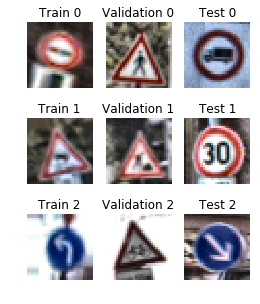

In [44]:
# sanity check : training, validation and test sets 
fig, ax = plt.subplots(3,3, figsize=(4,5))
for i in range(3) :
    ax[i,0].imshow(X_train[i])
    ax[i,0].set_title('Train '+str(i))
    ax[i,1].imshow(X_validation[i])
    ax[i,1].set_title('Validation '+str(i))
    ax[i,2].imshow(X_test[i])
    ax[i,2].set_title('Test '+str(i))
for axes in ax.flatten() :
    axes.axis('off')

print('Training data shape : ', X_train.shape)
print('Validation data shape : ', X_validation.shape)
print('Test data shape : ', X_test.shape)

### Model Architecture

As already explained, images in the same track are highly correlated and randomly distributing them between training and validation set defeats the purpose of validation. So, I selected one track (consisting of 30 images) per class for validation set. Although this is far from ideal in terms of size of validation set, it is still better that mixing highly correlated images between training and validation set. This still leaves way too many correlated images and at the same time not enough images in the training set. To resolve this problem, I augmented dataset by performing random scaling (range of [0.85,1.1]), rotation (+/- 17 degrees) and translation (+/- 2 pixels). Further, I also perturbed every consecutive image in the training set, idea being that any two consecutive images are highly correlated. To balance training dataset, I augmented dataset so that there are 5000 images per class. Note that besides image pre-processing (contrast-normalization), the validation and test sets were neither augmented, nor perturbed.

The model I have chosen is inspired by *VGGnet* architecture. Consider the following arrangement :
http://www.robots.ox.ac.uk/~vgg/research/very_deep/

* Conv. layer
* ReLu activation
* Conv. layer
* ReLu activation
* Pooling
* Dropout

This arrangement is repeated 3 times so that we have a total of 6 conv layers. These layers have 32, 32, 64, 64, 128 and 128 filters in that order. Each conv. layer uses 3x3 filters with stride=1 and padding=1. Pooling layer uses maxpool filters of size 2x2 with stride=2. This is followed by following arrangement :
* Full-connected layer
* ReLu activation
* Dropout
repeated twice. Each fully-connected layers has size of 128. Softmax function is applied on final output layer for computing loss.

In [45]:
DIR = 'models'
if not os.path.exists(DIR) :
    os.makedirs(DIR)

In [46]:
keep_prob = tf.placeholder(tf.float32) # for fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32) # for convolutional layers
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

class VGGnet :  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.0007) :
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Pooling. Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv) # dropout

        # Layer 3: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 4: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Pooling. Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 5: Convolutional. Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 6: Convolutional. Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Pooling. Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 7: Fully Connected. Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 8: Fully Connected. Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 9: Fully Connected. Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # accuracy 
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # save all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64) :
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset + BATCH_SIZE]
            y_pred[offset:offset + BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [47]:
# train model 1
EPOCHS = 30
BATCH_SIZE = 64
model_1 = VGGnet(n_out = n_classes)
model_name = "model_1"


In [21]:
### Train model 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(model_1.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = model_1.evaluate(X_validation, y_validation)
        print("EPOCH {} : Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))

    model_1.saver.save(sess, os.path.join(DIR,model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 0.753
EPOCH 2 : Validation Accuracy = 0.950
EPOCH 3 : Validation Accuracy = 0.980
EPOCH 4 : Validation Accuracy = 0.989
EPOCH 5 : Validation Accuracy = 0.988
EPOCH 6 : Validation Accuracy = 0.986
EPOCH 7 : Validation Accuracy = 0.982
EPOCH 8 : Validation Accuracy = 0.993
EPOCH 9 : Validation Accuracy = 0.993
EPOCH 10 : Validation Accuracy = 0.998
EPOCH 11 : Validation Accuracy = 0.991
EPOCH 12 : Validation Accuracy = 0.994
EPOCH 13 : Validation Accuracy = 0.991
EPOCH 14 : Validation Accuracy = 0.996
EPOCH 15 : Validation Accuracy = 0.995
EPOCH 16 : Validation Accuracy = 0.992
EPOCH 17 : Validation Accuracy = 0.992
EPOCH 18 : Validation Accuracy = 0.994
EPOCH 19 : Validation Accuracy = 0.997
EPOCH 20 : Validation Accuracy = 0.998
EPOCH 21 : Validation Accuracy = 0.991
EPOCH 22 : Validation Accuracy = 0.992
EPOCH 23 : Validation Accuracy = 0.997
EPOCH 24 : Validation Accuracy = 0.997
EPOCH 25 : Validation Accuracy = 0.991
EPOCH 26 : Validation

In [22]:
# test model 1

with tf.Session() as sess:
    model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
    #test_accuracy = model_1.evaluate(X_test, y_test)
    y_pred = model_1.y_predict(X_test)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.973


It is quite remarkable that VGGnet inspired CNN with only minor tweaks yields such a high test accuracy.
Let us now plot the confusion matrix to see where the model actually fails. Note that we plot the log of confusion matrix due to very high accuracy.


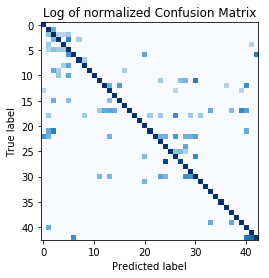

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001+cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

We observe some clusters in the confusion matrix above. It turns out that the various speed limits are sometimes misclassified among themselves. Similarly, traffic signs with traingular shape are misclassified among themselves. We can further improve on the model using hierarchical CNNs to first identify broader groups like speed signs and then have CNNs to classify finer features such as the actual speed limit.

I used Adam optimizer with learning rate = 0.007. Batch size of 64 was used and training was done for 30 epochs. The keep_prob for dropout layers was chosen to be 0.5 for conv layers and 0.7 for FC layers.

Starting with pre-processing stage, I tried several color channels including RGB, YUV and RGB with CLAHE. I chose RGB with CLAHE as it gave best results and I believe color carries useful information for our problem.
I chose architecture similar to VGGnet because deeper layers give better results and it is also quite elegant in the sense that same size filters for conv layers and pooling are used throughout.

Padding=1 or 'SAME' padding was used in conv layers to retain information at the borders of images.
Batch size and the size of FC layers was mostly constrained by memory issues, and adding more neurons in FC layers didn't seem to help much with the accuracy.

keep_prob in dropout for FC layers was chosen to be 0.7 because a smaller value of ~0.5 led to extremely slow convergence.

I used Adam optimizer as it seems to automatically tune the learning rate with time.


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [49]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
sign_names = pd.read_csv('signnames.csv')
sign_names.head(10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


length of images: 6


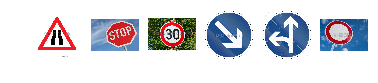

In [111]:
img_files = glob.glob('myData/*.jpg')
n_new = len(img_files)


print('length of images: {}'.format(n_new))

new_data = np.zeros((n_new, 32,32,3), dtype=np.uint8)
fig, ax = plt.subplots(1, n_new)

for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA) # resize to 32x32
    new_data[i] = img


I have taken these US traffic signs from the web. The stop sign looks fairly easy. No entry and yield signs look similar to German counterparts, although there are some differences too, namely the text on the signs. The speed limit sign looks very different from the corresponding German speed-limit sign, the only similarity being the number '70'. The left turn sign is completely different. So, I don't expect classifier to work on the left turn sign and possibly also fail on the speed limit sign.

### Predict the Sign Type for Each Image

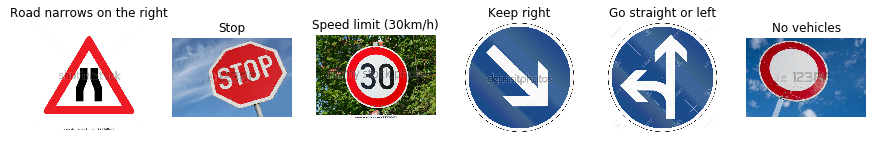

In [112]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(model_1.logits), k=top_k), 
                             feed_dict={x:X_data, keep_prob:1, keep_prob_conv:1})
    return y_prob,y_pred


# preprocess data  :
new_data_proc = np.zeros(new_data.shape)
for i in range(n_new):
    new_data_proc[i] = contrast_norm(new_data[i])
    
# make predictions
_, y_pred = y_predict_model(new_data_proc)

# show the prediction results
fig, ax = plt.subplots(1,n_new, figsize=(15,2))
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(sign_names.iloc[y_pred[i][0]]['SignName'])

I get an accuracy of 80% on the new dataset. This is actually better that what I had anticipated, my classifier worked even on the speed limit which looked very different from the German sign.

### Analyze Performance

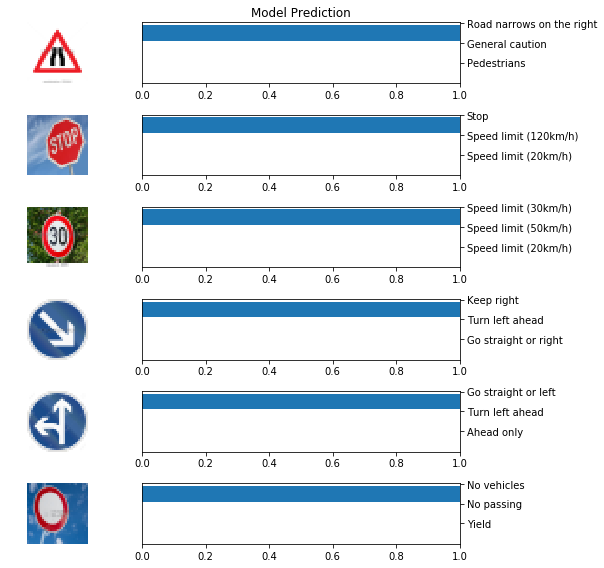

In [113]:

### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

        
def visualize_models(X_data) :
    n_examples = len(X_data)
    fig, ax = plt.subplots(n_examples, 2,figsize=(10,8))
    
    X_data_proc = np.zeros(X_data.shape)
    for i in range(n_examples):
        X_data_proc[i] = contrast_norm(X_data[i])
    prob, pred = y_predict_model(X_data_proc, top_k=3)
    
    for i in range(n_examples) :
        labels = pred[i]
        names = [sign_names.iloc[l]['SignName'] for l in labels]
        bar_locations = np.arange(3)[::-1]
        ax[i,0].imshow(X_data[i])
        ax[i,0].axis('off')
        ax[i,1].barh(bar_locations, prob[i])
        ax[i,1].set_yticks(0.5+bar_locations)
        ax[i,1].set_yticklabels(names)
        ax[i,1].yaxis.tick_right()
        ax[i,1].set_xlim([0,1])
    ax[0,1].set_title('Model Prediction')
    fig.tight_layout()
    
visualize_models(new_data)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [55]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")